In [94]:
from __future__ import division

import os
import urllib, cStringIO

import pymongo as pm

import matplotlib
from matplotlib import pylab, mlab, pyplot
%matplotlib inline
from IPython.core.pylabtools import figsize, getfigs
plt = pyplot
import seaborn as sns
sns.set_context('poster')
sns.set_style('white')

import numpy as np
import scipy.stats as stats
import pandas as pd
import json
import re

from PIL import Image
import base64
import sys

from svgpathtools import parse_path

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")

## setup

In [95]:
# directory & file hierarchy
proj_dir = os.path.abspath('../../..')
analysis_dir = os.getcwd()
results_dir = os.path.join(proj_dir,'results')
plot_dir = os.path.join(results_dir,'plots')
csv_dir = os.path.join(results_dir,'csv')
exp_dir = os.path.abspath(os.path.join(proj_dir,'experiments'))
sketch_dir = os.path.abspath(os.path.join(proj_dir,'sketches'))

## add helpers to python path
if os.path.join(proj_dir,'analysis','python') not in sys.path:
    sys.path.append(os.path.join(proj_dir,'analysis','python'))
    
if not os.path.exists(results_dir):
    os.makedirs(results_dir)
    
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)   
    
if not os.path.exists(csv_dir):
    os.makedirs(csv_dir)       
    
# Assign variables within imported analysis helpers
import analysis_helpers as h
if sys.version_info[0]>=3:
    from importlib import reload
reload(h)

<module 'analysis_helpers' from '/Users/judithfan/graphical_conventions/analysis/python/analysis_helpers.pyc'>

In [101]:
# set vars 
auth = pd.read_csv('auth.txt', header = None) # this auth.txt file contains the password for the sketchloop user
pswd = auth.values[0][0]
user = 'sketchloop'
host = 'rxdhawkins.me' ## cocolab ip address

# have to fix this to be able to analyze from local
import pymongo as pm
conn = pm.MongoClient('mongodb://sketchloop:' + pswd + '@127.0.0.1')
db = conn['3dObjects']
coll = db['graphical_conventions']

# which iteration name should we use?
iterationName = 'run2_chairs1k_size6'

In [102]:
## get total number of stroke and clickedObj events in the collection as a whole
S = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'stroke'}]}).sort('time')
C = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}]}).sort('time')
print str(S.count()) + ' stroke records in the database.'
print str(C.count()) + ' clickedObj records in the database.'

1136 stroke records in the database.
214 clickedObj records in the database.


## generate group dataframe

In [103]:
## list of researcher mturk worker ID's to ignore
jefan = ['A1MMCS8S8CTWKU','A1MMCS8S8CTWKV','A1MMCS8S8CTWKS']
hawkrobe = ['A1BOIDKD33QSDK']
megsano = ['A1DVQQLVZR7W6I']
researchers = jefan + hawkrobe + megsano

In [104]:
reload(h)
## get list of all candidate games
games = coll.distinct('gameid')

## get list of complete and valid games
complete_games = h.get_complete_and_valid_games(games,coll,iterationName,
                                                researchers=researchers, 
                                                tolerate_undefined_worker=False,
                                                verbose=False)

There are 4 complete games in total.


In [105]:
print complete_games

[u'9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993', u'8640-15cf6802-aa7c-4aff-8b9c-90c680eefa73', u'9340-a1124706-24cc-44f3-9097-ba0b33adbf36', u'3511-727c76f4-f755-48e9-8fc8-b61efbe785c9']


In [108]:
short_list = complete_games[2:3]

In [109]:
reload(h)

# preprocessing 

TrialNum = []
GameID = []
Condition = []
Target = []
Category = []
Distractor1 = []
Distractor2 = []
Distractor3 = []
Outcome = []
Response = []
Repetition = []
Phase = []
numStrokes = []
drawDuration = [] # in seconds
svgStringLength = [] # sum of svg string for whole sketch
svgStringLengthPerStroke = [] # svg string length per stroke
numCurvesPerSketch = [] # number of curve segments per sketch
numCurvesPerStroke = [] # mean number of curve segments per stroke
svgStringStd = [] # std of svg string length across strokes for this sketch
Outcome = [] #accuracy (True or False)
png=[] # the sketch 
timedOut=[] # True if sketchers didn't draw anything, False o.w.
meanPixelIntensity=[]

for i,g in enumerate(short_list):
        print 'Analyzing game {} | {} of {}: '.format(g, i, len(complete_games))

        # collection of all clickedObj events in a particular game 
        X = coll.find({ '$and': [{'gameid': g}, {'eventType': 'clickedObj'}]}).sort('time')
        print X.count()
        # collection of all stroke events in a particular game 
        Y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}]}).sort('time')

        for t in X: # for each clickedObj event
            targetname = t['intendedName']
            category = h.OBJECT_TO_CATEGORY_run2[targetname]
            Phase.append(t['phase'])
            Repetition.append(t['repetition'])
            distractors = [t['object2Name'],t['object3Name'],t['object4Name']]
            full_list = [t['intendedName'],t['object2Name'],t['object3Name'],t['object4Name']] 
            png.append(t['pngString'])

            #for each stroke event with same trial number as this particular clickedObj event 
            y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')
            # have to account for cases in which sketchers do not draw anything 
            if (y.count() == 0):
                numStrokes.append(float('NaN'))
                drawDuration.append(float('NaN'))
                svgStringLength.append(float('NaN'))
                svgStringLengthPerStroke.append(float('NaN'))
                numCurvesPerSketch.append(float('NaN'))
                numCurvesPerStroke.append(float('NaN'))
                svgStringStd.append(float('NaN'))
                meanPixelIntensity.append('NaN')
                timedOut.append(True)
            else: 
                # calculate numStrokes 
                lastStrokeNum = float(y[y.count() - 1]['currStrokeNum']) # get currStrokeNum at last stroke
#                 numStrokes.append(lastStrokeNum)
                ns = y.count()
                assert lastStrokeNum == ns
                numStrokes.append(ns)
                
                # calculate drawDuration 
                startStrokeTime =  float(y[0]['startStrokeTime'])
                endStrokeTime = float(y[y.count() - 1]['endStrokeTime']) ## took out negative 1 
                duration = (endStrokeTime - startStrokeTime) / 1000
                drawDuration.append(duration)
                
                # calculate other measures that have to do with sketch 
                ls = [len(_y['svgData']) for _y in y]
                svgStringLength.append(sum(ls))
                y = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum': t['trialNum']}]}).sort('time')            
                num_curves = [len([m.start() for m in re.finditer('c',str(_y['svgData']))]) for _y in y] ## gotcha: need to call string on _y['svgData'], o/w its unicode and re cant do anything with it
                numCurvesPerSketch.append(sum(num_curves))
                numCurvesPerStroke.append(sum(num_curves)/lastStrokeNum)
                svgStringLengthPerStroke.append(sum(ls)/lastStrokeNum)
                svgStringStd.append(np.std(ls))
                timedOut.append(False)
                
                ## calculate pixel intensity (amount of ink spilled) 
            
                imsize = 100
                numpix = imsize**2
                thresh = 250
                imgData = t['pngString']
                filestr = base64.b64decode(imgData)
                fname = os.path.join('sketch.png')
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                im = Image.open(fname).resize((imsize,imsize))
                _im = np.array(im)
                meanPixelIntensity.append(len(np.where(_im[:,:,3].flatten()>thresh)[0])/numpix)

            ### aggregate game metadata
            TrialNum.append(t['trialNum'])
            GameID.append(t['gameid'])        
            Target.append(targetname)
            Category.append(category)
            Condition.append(t['condition'])
            Response.append(t['clickedName'])
            Outcome.append(t['correct'])
            Distractor1.append(distractors[0])
            Distractor2.append(distractors[1])
            Distractor3.append(distractors[2])  

Analyzing game 9340-a1124706-24cc-44f3-9097-ba0b33adbf36 | 0 of 4: 
48


##### svg rendering

In [15]:
import svg_rendering_helpers as srh
reload(srh)

<module 'svg_rendering_helpers' from 'svg_rendering_helpers.pyc'>

In [154]:
g = '3511-727c76f4-f755-48e9-8fc8-b61efbe785c9'

In [155]:
## example sketch from trial one of some game
stroke_recs = coll.find({ '$and': [{'gameid': g}, {'eventType': 'stroke'}, {'trialNum':25}]}).sort('time')

In [156]:
stroke_recs.count()

18

In [157]:
svg_list = srh.make_svg_list(stroke_recs)

In [158]:
from matplotlib.path import Path
import matplotlib.patches as patches

In [205]:
svg_list

[u'M90,196c0,-5.09807 -6.19823,-14.89497 -8,-20c-6.26025,-17.73738 -9,-37.20638 -9,-56',
 u'M74,117c11.74683,-23.49366 51.81428,-36.46703 74,-45c11.50511,-4.42504 20.39285,-15.13095 32,-19',
 u'M177,54c7.86592,5.24394 43.76194,36 53,36',
 u'M230,88c4.61694,4.61694 11.3147,8.47205 15,14c7.11402,10.67103 23.31885,81.68115 13,92',
 u'M56,227c33.58518,-33.58518 88.2295,-41 134,-41c6.74832,0 89.02719,8 68,8',
 u'M59,229c3.51022,3.51022 2.65467,8.65467 6,12c4.76237,4.76237 42.83263,-10.55509 48,-14c3.96662,-2.64441 3.94425,-6.94425 7,-10',
 u'M121,214c0,-2.30587 28.66961,-1 32,-1c8.86159,0 91.20359,4.79641 98,-2',
 u'M251,211c10.53794,0 30.62218,-17 13,-17',
 u'M135,217c2.13437,0 3.43841,2.94083 4,5c4.89134,17.93491 12,43.36263 12,62',
 u'M228,218c12.38292,0 27.83216,70 19,70',
 u'M79,161c-0.81098,0 -5.38952,20.94762 -6,24c-1.41104,7.05519 3.47351,13.63245 2,21c-1.6564,8.28202 -9.29709,12.48546 -11,21c-1.67236,8.3618 2,21.72782 2,31',
 u'M76,163c5.48368,0 7.04908,7.31135 10,11c2.83483,3.5435

In [208]:
type(parsed[0])

svgpathtools.path.CubicBezier

In [160]:
curves = []
Verts = []
Codes = []
for stroke_ind,stroke in enumerate(svg_list):
    x = []
    y = []
    parsed = parse_path(stroke)
    for i,p in enumerate(parsed):
        x.append(p.start.real)
        y.append(p.start.imag)  
        x.append(p.control1.real)
        y.append(p.control1.imag) 
        x.append(p.control2.real)
        y.append(p.control2.imag)
        x.append(p.end.real)
        y.append(p.end.imag)
    assert len(zip(x,y))%4==0
    curves.append(zip(x,y))

In [161]:
parsed

Path(CubicBezier(start=(214+103j), control1=(214+122.33333j), control2=(214+141.66667j), end=(214+161j)))

In [162]:
len(curves)

18

In [130]:
parsed

Path(Line(start=(124+82j), end=(124+82j)),
     CubicBezier(start=(124+82j), control1=(126.40697+94.03486j), control2=(131.0048+106.01441j), end=(135+118j)),
     CubicBezier(start=(135+118j), control1=(141.95122+138.85367j), control2=(155+165.038j), end=(155+187j)))

In [129]:
svg_list[stroke_ind]

u'M124,82v0c2.40697,12.03486 7.0048,24.01441 11,36c6.95122,20.85367 20,47.038 20,69'

In [185]:
curves[0]

[(90.0, 196.0),
 (90.0, 190.90193),
 (83.80177, 181.10503),
 (82.0, 176.0),
 (82.0, 176.0),
 (75.73975, 158.26262),
 (73.0, 138.79362),
 (73.0, 120.0)]

In [191]:
def polycurve_pathmaker(curves):
    x = []    
    y = []    
    codes = []
    stroke_ind = []
    for i,l in enumerate(curves):
        for _i,_l in enumerate(l):
            x.append(_l[0])
            y.append(_l[1])
            stroke_ind.append(i)
            if _i%4==0:
                codes.append(Path.MOVETO)
            else:
                codes.append(Path.CURVE4) # remaining control and endpoints for each spline
    verts = zip(x,y) 
    return verts, codes, stroke_ind

In [199]:
verts, codes, stroke_ind = polycurve_pathmaker(curves)
verts, codes, stroke_ind = map(np.array,[verts, codes, stroke_ind])

In [197]:
assert len(stroke_ind)==len(verts)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17])

In [201]:
verts[stroke_ind==0]

array([[ 90.     , 196.     ],
       [ 90.     , 190.90193],
       [ 83.80177, 181.10503],
       [ 82.     , 176.     ],
       [ 82.     , 176.     ],
       [ 75.73975, 158.26262],
       [ 73.     , 138.79362],
       [ 73.     , 120.     ]])

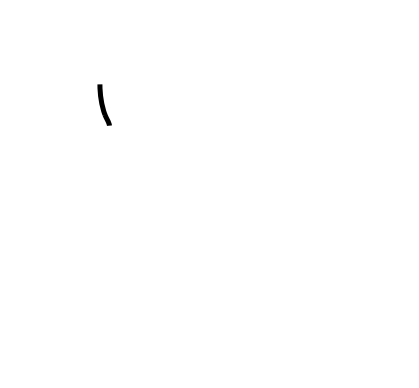

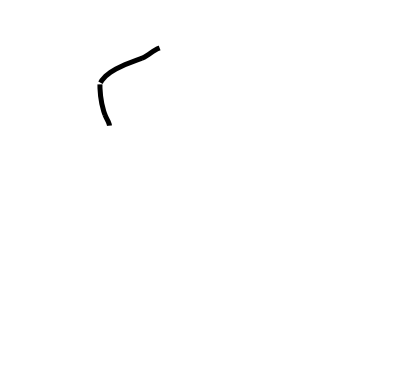

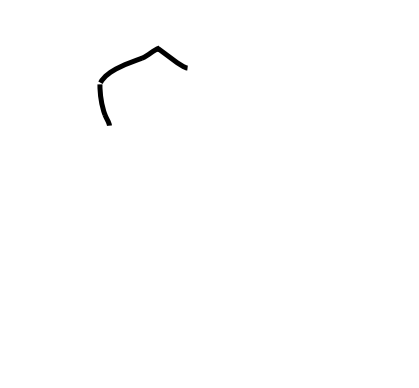

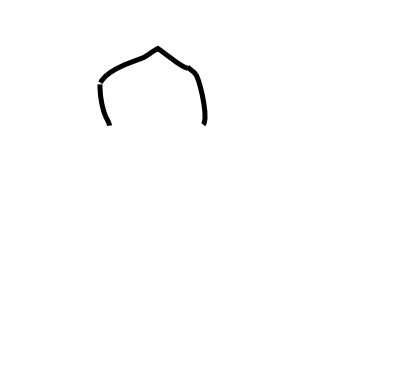

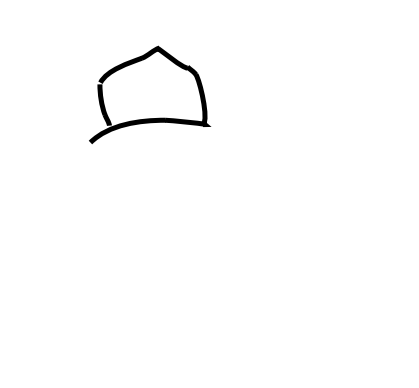

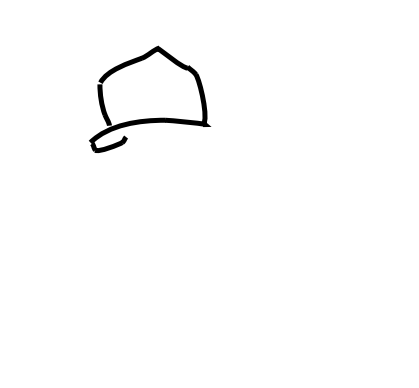

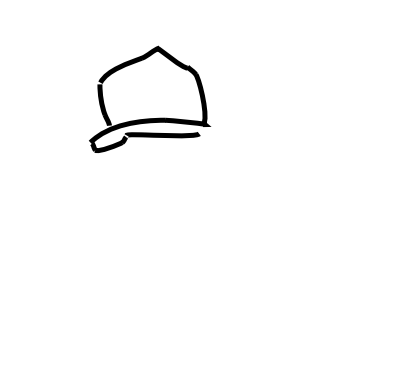

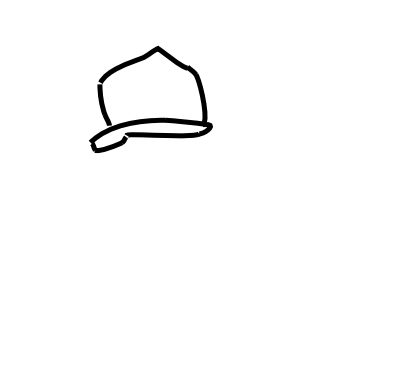

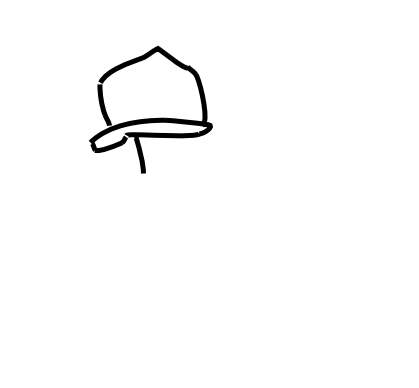

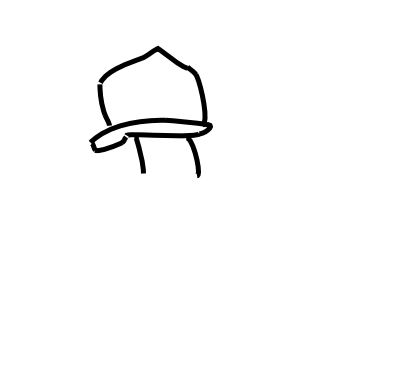

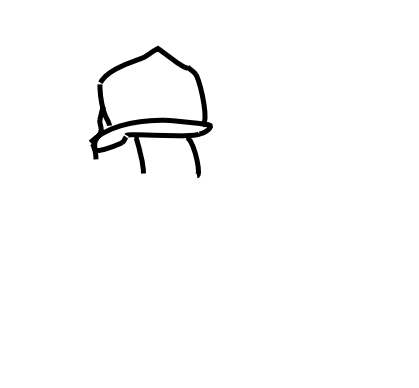

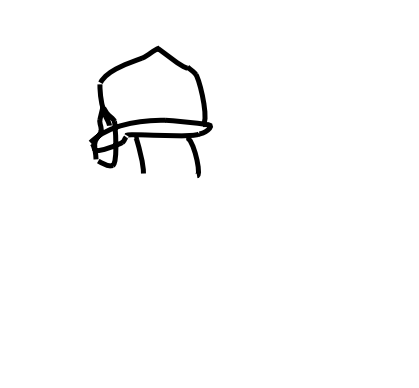

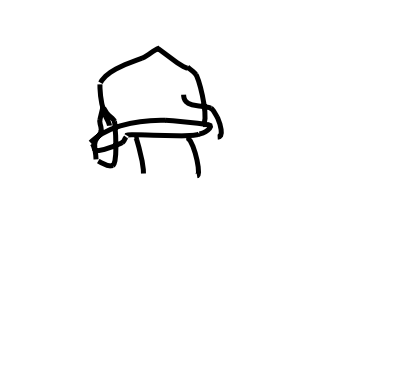

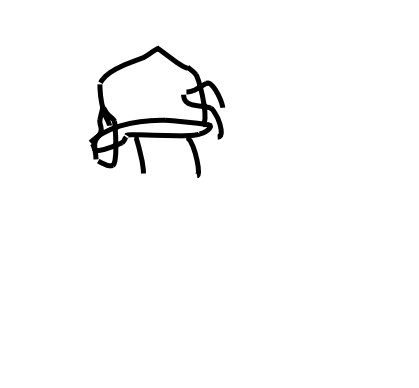

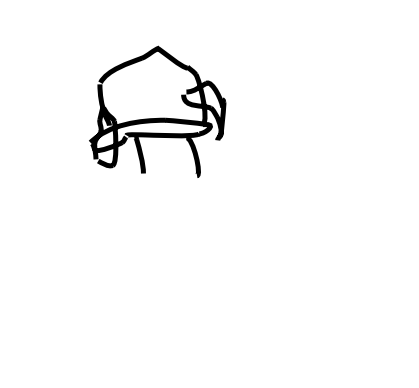

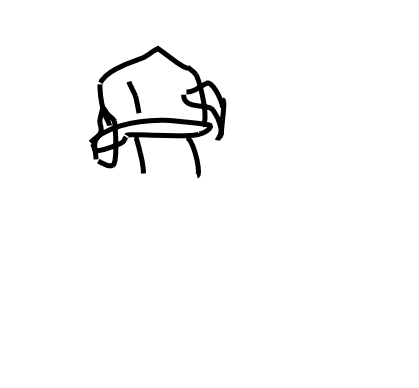

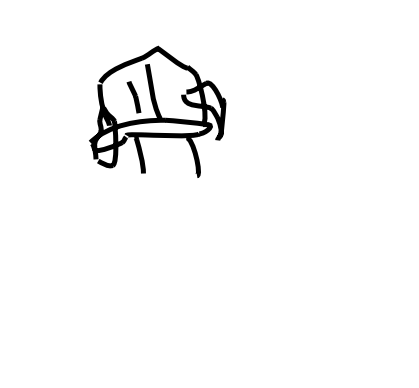

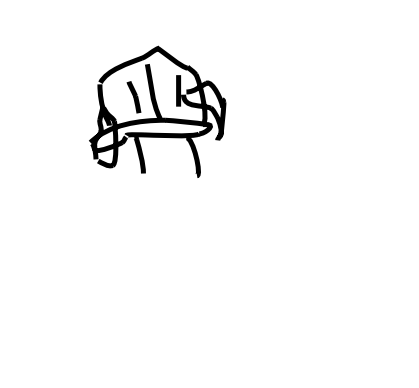

In [204]:
imsize=6
canvas_size=600
line_width=5

### render sketch so far


unique_stroke_inds = np.unique(stroke_ind)
for i,ind in enumerate(unique_stroke_inds):
    fig = plt.figure(figsize=(imsize,imsize))    
    ax = plt.subplot(111)
    ax.axis('off')
    ax.set_xlim(0,canvas_size)
    ax.set_ylim(0,canvas_size)     
    these_verts = verts[stroke_ind<=i]
    these_codes = codes[stroke_ind<=i]
    path = Path(these_verts, these_codes)
    patch = patches.PathPatch(path, facecolor='none', edgecolor='black', lw=line_width)
    ax.add_patch(patch)
    plt.gca().invert_yaxis() # y values increase as you go down in image        
    plt.show()

In [60]:
for i,g in enumerate(complete_games[:1]):    
    image_recs = coll.find({'$and': [{'gameid':g}, {'eventType':'clickedObj'}]}).sort('time')    
    num_drawings = image_recs.count()
    if num_drawings > 3:
        print 'Great! Number of drawings made by this person: {}'.format(image_recs.count())        
        ### now try looping through all images made during this session and render out
        try:
            image_recs = coll.find({'$and': [{'gameid':g}, {'eventType':'clickedObj'}]}).sort('time')    
            for imrec in image_recs:       
                ## now loop through all the strokes comprising this sketch 
                stroke_recs = coll.find({'$and': [
                                          {'gameid':g}, 
                                          {'eventType':'stroke'},
                                          {'trialNum': imrec['trialNum']}]}).sort('time')  
                ## check to make sure that there is at least one stroke! 
                assert stroke_recs.count()>0

                ## some handy metadata for writing out the sketch PNG filename
                trial_num = stroke_recs[0]['trialNum']
                category = stroke_recs[0]['category']
                game_id = stroke_recs[0]['gameid']

                ## now make an svg list!
                svg_list = srh.make_svg_list(stroke_recs)

                ## now get me some verts and codes!
                Verts, Codes = srh.get_verts_and_codes(svg_list)

#                 ## now render out your cumulative sketches and save out as pngs!
#                 srh.render_and_save(Verts,
#                                 Codes,
#                                 line_width=5,
#                                 imsize=8,
#                                 canvas_size=600,
#                                 game_id=game_id,
#                                 trial_num=trial_num,
#                                 category=category)

        except Exception as e:
            print 'Oops, something went wrong! Here is the error:'  
            print e
            pass

Great! Number of drawings made by this person: 48
Oops, something went wrong! Here is the error:
'category'


In [ ]:
## now actually make dataframe
GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity, svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png = map(np.array, \
[GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut,png])    

Repetition = map(int,Repetition)

D = pd.DataFrame([GameID,TrialNum,Condition, Target, Category, Repetition, Phase, drawDuration, Outcome, Response, numStrokes, meanPixelIntensity,svgStringLength, svgStringLengthPerStroke, svgStringStd, numCurvesPerSketch, numCurvesPerStroke, timedOut, png], 
                 index = ['gameID','trialNum','condition', 'target', 'category', 'repetition', 'phase', 'drawDuration', 'outcome', 'response', 'numStrokes', 'meanPixelIntensity', 'svgStringLength', 'svgStringLengthPerStroke', 'svgStringStd', 'numCurvesPerSketch', 'numCurvesPerStroke', 'timedOut', 'png'])
D = D.transpose()

## save out dataframe to be able to load in and analyze later w/o doing the above mongo querying ...
D.to_csv(os.path.join(results_dir,'graphical_conventions_group_data_{}.csv'.format(iterationName)))

# Just look at one game 
#D = D[D['gameID'] == '3511-727c76f4-f755-48e9-8fc8-b61efbe785c9']

# Just look at repeated trials and sort them by target and reps 
# _D = D[(D.condition=='repeated')]
# _D = _D.sort_values(by=['target','repetition'])
D

##### seeing how previous trial accuracy affects numStrokes in the current trial

In [ ]:
D.shape[0]

In [ ]:
falseNumStrokes = []
trueNumStrokes = []
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        if d['outcome'] == False:
            nextNumStrokes = D['outcome'][i+1]
            falseNumStrokes.append(nextNumStrokes)
        else:
            nextNumStrokes = D['outcome'][i+1]
            trueNumStrokes.append(nextNumStrokes)

In [ ]:
meanNumStrokesGivenFalse = sum(falseNumStrokes)/float(len(falseNumStrokes))
meanNumStrokesGivenTrue =  sum(trueNumStrokes)/float(len(trueNumStrokes))
print meanNumStrokesGivenFalse, meanNumStrokesGivenTrue

In [ ]:
## adding previous outcomes to each trial 
previousOutcome = []
previousOutcome.append('NaN')
for i, d in D.iterrows():
    if (i != D.shape[0] - 1):
        previousOutcome.append(d['outcome'])
D['previousOutcome'] = pd.Series(previousOutcome)

In [ ]:
## conditioning on previous trial outcome being true 
D_true = D[D['previousOutcome'] == True]
reload(h)
dv = 'numStrokes'
h.ts_repeated_control(D_true, 
                        var=dv,
                        numReps = 6,
                        limit=10, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

### confusion matrix for each category

In [ ]:
reload(h)

In [ ]:
h.get_confusion_matrix(D, 'armchair', 6)

In [ ]:
h.get_confusion_matrix(D, 'waiting', 6)

In [ ]:
h.get_confusion_matrix(D, 'dining', 6)

In [ ]:
h.get_confusion_matrix(D, 'deck', 6)

In [ ]:
category = 'waiting'
set_size = 6

_D = D[D['condition'] == 'repeated']
_D = _D[_D['repetition'] >= 5]
target_list = _D['target'].tolist()
obj_list_ = []
obj_list = []
objlist = h.CATEGORY_TO_OBJECT_run2[category]
for obj in objlist[:set_size*2]:
    obj_list_.append(obj)
for i in obj_list_:
    if i in target_list:
        obj_list.append(i)

## initialize confusion matrix 
confusion = np.zeros((len(obj_list), len(obj_list)))

## generate confusion matrix by incrementing each cell 
for i, d in _D.iterrows():
    if d['category'] == category:
        targ_ind = obj_list.index(d['target'])
        chosen_ind = obj_list.index(d['response'])
        confusion[targ_ind, chosen_ind] += 1

## normalize confusion matrix 
normed = np.zeros((len(obj_list), len(obj_list)))
for i in np.arange(len(confusion)):
    normed[i,:] = confusion[i,:]/np.sum(confusion[i,:])

## plot confusion matrix 
from matplotlib import cm
fig = plt.figure(figsize=(8,8))
ax = plt.subplot(111)
cax = ax.matshow(normed,vmin=0,vmax=1,cmap=cm.viridis)
plt.xticks(range(len(normed)), obj_list, fontsize=12,rotation='vertical')
plt.yticks(range(len(normed)), obj_list, fontsize=12)
plt.colorbar(cax,shrink=0.8)
plt.tight_layout()
#plt.savefig('./plots/confusion_matrix_all.pdf')
#plt.close(fig)

## visualize behavioral measures over time

In [ ]:
# reload analysis_helpers just to be on the safe side 
reload(h)

## set seaborn style params here
sns.set_context('poster')
sns.set_style('white')

##### Accuracy over time

In [ ]:
total = 0
for outcome in D['outcome']:
    total = total + outcome 
meanAccuracy = total / len(D['outcome'])
meanAccuracy

In [ ]:
mean_accuracy_list = []
for i in range(0,6):
    outcome_list = (D.loc[D['repetition'] == i])['outcome']
    mean_accuracy = sum(outcome_list) / float(len(outcome_list))
    mean_accuracy_list.append(mean_accuracy)
D_mean = pd.DataFrame()
D_mean['meanAccuracy'] = mean_accuracy_list
D_mean['repetition'] = range(0,6)
D_mean
plt.figure(figsize=(6,6))
sns.regplot(data=D_mean,
         x='repetition',
         y='meanAccuracy',
         ci = None)    
plt.ylim([0.5,1.0])

### plot time series during repetition phase 

##### individual measures across reps (repeated trials only)

In [ ]:
# What is the measure that you want to visualize across reps? 
dv = 'numCurvesPerSketch'

In [ ]:
# D0 = h.ts_repeated(D,
#                                     var=dv,
#                                     limit=20, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
#                                     save_plot=False,
#                                     plot_dir=plot_dir)

##### individual measures across reps (repeated + control)

In [ ]:
reload(h)
h.ts_repeated_control(D, 
                        var=dv,
                        numReps = 6,
                        limit=40, # recommended limits: 'numStrokes' : 6, 'drawDuration' : 10, 'numCurvesPerSketch' : 20, 'numCurvesPerStroke' : 6 
                        save_plot=False,
                        plot_dir=plot_dir)

##### 4 measures (2x2) across reps (repeated + control) 

In [ ]:
# What are the four measures that you want to visualize across reps? 
var0='numStrokes'
var1='drawDuration'
var2='numCurvesPerSketch'
var3='numCurvesPerStroke'

In [ ]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

###  Subhelper 1

def collapse_within_repetition(D, var, condition, numReps):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition','category'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition','category'])[var].mean()).reset_index()).replace(1,numReps-1)


D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

## collapsing across objects within repetition (within pair) 
## and only aggregating repeated trials into this sub-dataframe
D0 = collapse_within_repetition(D, var0, 'repeated', 6)
D1 = collapse_within_repetition(D, var1, 'repeated', 6)
D2 = collapse_within_repetition(D, var2, 'repeated', 6)
D3 = collapse_within_repetition(D, var3, 'repeated', 6)

#fig = plt.figure(figsize=(12,12))
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(nrows=2, ncols=2, figsize=(10,10))

## make sure that the number of timepoints now per gameID is equal to the number of repetitions in the game
num_reps = len(np.unique(D.repetition.values))
assert D0.groupby('gameID')['gameID'].count()[0]==num_reps    

sns.lineplot(data=D0,
           x='repetition',
           hue='category',
           #unit='gameID',
           y=var0,
           ax=ax0,
           legend = False)

sns.lineplot(data=D1,
           x='repetition',
           hue='category',
           #unit='gameID',
           y=var1,
           ax=ax1,
           legend = False)

sns.lineplot(data=D2,
           x='repetition',
           hue='category',
           #unit='gameID',
           y=var2,
           ax=ax2,
           legend = False)

sns.lineplot(data=D3,
           x='repetition',
           hue='category',
           #unit='gameID',
           y=var3,
           ax=ax3)

plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
plt.xticks(np.arange(np.max(D0['repetition'])+1))
ax3.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)

In [ ]:
reload(h)
h.ts_grid_repeated_control(D, 
                                                var0, var1, var2, var3,
                                                numReps=6,
                                                 save_plot=False,
                                                 plot_dir=plot_dir)

### compare conditions in pre and post phases 

In [ ]:
D1 = h.compare_conditions_prepost(D,
                                var='drawDuration',
                                limit=20,
                                save_plot=False,
                                plot_dir=plot_dir)

##### compare accuracy in pre and post phases (repeated vs control conditions)

In [ ]:
for i, o in enumerate(D['outcome']):
    if o == True:
        D.set_value(i, 'outcome', 1)
    else:
        D.set_value(i, 'outcome', 0)
D['outcome'] = D['outcome'].astype(int)

In [ ]:
_D1 = D[D['phase']!='repeated'] ## exclude "repetition-phase" trials
D1 = _D1.groupby(['gameID','phase','condition'])['outcome'].mean()
D1 = D1.reset_index()    

plt.figure(figsize=(6,6))
sns.pointplot(data=D1,
         x='phase',
         y='outcome',
         hue='condition',
         order=['pre','post'])    
plt.ylim([0,1.1])
#plt.savefig(os.path.join(plot_dir,'timeseries_across_reps_{}.pdf'.format(var))) 
#return D1    

 ### visualize how sketches are changing across repetitions

In [ ]:
# print_repeated_sketches(D,
#                                      complete_games,
#                                      sketch_dir)

In [ ]:
# print_control_sketches(D,
#                                    complete_games,
#                                    sketch_dir)

##### printing actual sketches next to repeated sketches

In [ ]:
index = list(range(1, 43))
new_index = filter(lambda x: x%7!=0, index)

In [ ]:
for g in complete_games:
    print 'Printing out sketches from game: ' + g
    trial_types = ['repeated']
    for tt in trial_types:
        _D = D[(D.condition=='repeated') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 0
        textsize=12
        fig = plt.figure(figsize=(10,10))
        for i,_d in _D.iterrows():
            true_index = new_index[_i]
            if _i %6 == 0:
                target = _d['target']
                dir_path = 'chairs1k_pilot'
                png_name = target + '.png'
                path = os.path.join(dir_path, png_name)
                im = Image.open(path)
                cropped_im = im.crop((350, 150, 600, 400))
                p = plt.subplot(6,7,true_index+6)
                plt.imshow(cropped_im)
                sns.set_style('white')
                k = p.get_xaxis().set_ticklabels([])
                k = p.get_yaxis().set_ticklabels([])
                k = p.get_xaxis().set_ticks([])
                k = p.get_yaxis().set_ticks([]) 
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(6,7,true_index)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i < 6) & (tt in 'repeated'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if _i%6==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)
            
                

            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
        if not os.path.exists(os.path.join(sketch_dir,'repeated')):
            os.makedirs(os.path.join(sketch_dir,'repeated'))
        plt.tight_layout()

In [ ]:
D_ = D[(D.condition=='control') & (D.gameID=='9276-b328e584-c3fb-4a8f-b5a9-1b5f88292993')]
D__ = D_[(D_.phase == 'post')]
D__['outcome']

##### printing last sketch of control condition next to repeated sketches 

In [ ]:
for g in complete_games:
    print 'Printing out sketches from game: ' + g
    trial_types = ['repeated']
    for tt in trial_types:
        _D = D[(D.condition=='repeated') & (D.gameID==g)]
        D_ = D[(D.condition=='control') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 0
        control_index = 0
        textsize=12
        fig = plt.figure(figsize=(10,10))
        for i,_d in _D.iterrows():
            true_index = new_index[_i]
            if _i %6 == 0:
                # plot last of control sketch 
                target = _d['target']
                D__ = D_[D_.phase == 'post']
                imgData = D__['png'].iloc[control_index]
                filestr = base64.b64decode(imgData)
                fname = 'sketch.png'
                with open(fname, "wb") as fh:
                    fh.write(imgData.decode('base64'))
                textsize = 16
                # first plot the target
                im = Image.open(fname)
                p = plt.subplot(6,7,true_index+6)
                plt.imshow(im)
                if (_i < 6):
                    plt.title('control' ,fontsize=textsize)
                sns.set_style('white')
                k = p.get_xaxis().set_ticklabels([])
                k = p.get_yaxis().set_ticklabels([])
                k = p.get_xaxis().set_ticks([])
                k = p.get_yaxis().set_ticks([]) 
                outcome = D__['outcome'].iloc[control_index]
                if outcome == 1:
                    sides = ['bottom','top','right','left']
                    for s in sides:
                        p.spines[s].set_color((0.4,0.8,0.4))
                        p.spines[s].set_linewidth(4)                               
                else:
                    sides = ['bottom','top','right','left']
                    for s in sides:
                        p.spines[s].set_color((0.9,0.2,0.2))
                        p.spines[s].set_linewidth(4)    
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(6,7,true_index)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i < 6) & (tt in 'repeated'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if _i%6==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)
                control_index = control_index + 1
                
            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'repeated','{}_{}.pdf'.format(g,category))                                                                
        if not os.path.exists(os.path.join(sketch_dir,'repeated')):
            os.makedirs(os.path.join(sketch_dir,'repeated'))
        plt.tight_layout()

##### printing control sketches

In [ ]:
_valid_gameids = complete_games

for g in _valid_gameids:
    print 'Printing out sketches from game: ' + g
    trial_types = ['control']
    for tt in trial_types:
        _D = D[(D.condition=='control') & (D.gameID==g)]
        all_targs = np.unique(_D.target.values) ## use this later to name the file
        _D = _D.sort_values(by=['target','repetition'])
        _i = 1
        textsize=12
        fig = plt.figure(figsize=(5,10))
        for i,_d in _D.iterrows():
            imgData = _d['png']
            filestr = base64.b64decode(imgData)
            fname = 'sketch.png'
            with open(fname, "wb") as fh:
                fh.write(imgData.decode('base64'))
            textsize = 16
            # first plot the target
            im = Image.open(fname)
            p = plt.subplot(6,2,_i)
            plt.imshow(im)
            sns.set_style('white')
            k = p.get_xaxis().set_ticklabels([])
            k = p.get_yaxis().set_ticklabels([])
            k = p.get_xaxis().set_ticks([])
            k = p.get_yaxis().set_ticks([]) 
            outcome = _d['outcome']
            category = _d['category']
            if outcome == 1:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.4,0.8,0.4))
                    p.spines[s].set_linewidth(4)                               
            else:
                sides = ['bottom','top','right','left']
                for s in sides:
                    p.spines[s].set_color((0.9,0.2,0.2))
                    p.spines[s].set_linewidth(4)    
            if (_i-1 < 2) & (tt in 'control'): 
                plt.title('rep ' + str(_d['repetition']) ,fontsize=textsize)
            if (_i-1)%2==0:
                plt.ylabel(_d['target'] ,fontsize=textsize)

            _i  = _i + 1

        filepath = os.path.join(sketch_dir,'control','{}_{}.pdf'.format(g,category))     
        if not os.path.exists(os.path.join(sketch_dir,'control')):
            os.makedirs(os.path.join(sketch_dir,'control'))
        #plt.savefig(os.path.join(sketch_dir,'control',filepath))
        #plt.close(fig)

### WORKING AREA

In [ ]:
## collapsing across objects within repetition (within pair) 
D0_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()
D1_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()
D2_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()
D3_repeated = (D_repeated.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()

D0_control = ((D_control.groupby(['gameID','repetition','condition'])[var0].mean()).reset_index()).replace(1, 7) # rescale control reps 
D1_control = ((D_control.groupby(['gameID','repetition','condition'])[var1].mean()).reset_index()).replace(1, 7) # rescale control reps 
D2_control = ((D_control.groupby(['gameID','repetition','condition'])[var2].mean()).reset_index()).replace(1, 7) # rescale control reps 
D3_control = ((D_control.groupby(['gameID','repetition','condition'])[var3].mean()).reset_index()).replace(1, 7) # rescale control reps 

In [ ]:

# sns.tsplot(data=D0_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var0,
#            ax=ax0)

# sns.tsplot(data=D0_control,
#                time='repetition',
#                unit='gameID',
#                value=var0,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax0,
#                color='r')

# sns.tsplot(data=D1_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var1,
#            ax=ax1)

# sns.tsplot(data=D1_control,
#                time='repetition',
#                unit='gameID',
#                value=var1,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax1,
#                color='r')

# sns.tsplot(data=D2_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var2,
#            ax=ax2)

# sns.tsplot(data=D2_control,
#                time='repetition',
#                unit='gameID',
#                value=var2,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax2,
#                color='r')

# sns.tsplot(data=D3_repeated,
#            time='repetition',
#            unit='gameID',
#            value=var3,
#            ax=ax3)

# sns.tsplot(data=D3_control,
#                time='repetition',
#                unit='gameID',
#                value=var3,
#                err_style='ci_bars',
#                interpolate=False,
#                ax=ax3,
#                color='r')

# plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
# ax0.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax1.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax2.set(xlim=(-0.5, 7.5), xticks=range(0,8))
# ax3.set(xlim=(-0.5, 7.5), xticks=range(0,8))

In [ ]:
# for i in range(0, 4):
#     var = 'var'+ i
#     print var
#     'D' + str(i) + '_' + condition = collapse_within_repetition(D, var, condition)

In [ ]:
def convert_numeric(X,column_id):
    ## make numeric types for aggregation
    X[column_id] = pd.to_numeric(X[column_id])
    return X

D = convert_numeric(convert_numeric(convert_numeric(convert_numeric(D,var0),var1),var2),var3) 

def collapse_within_repetition(D, var, condition):
    _D = D[D['condition']==condition]
    if condition == 'repeated':
        return (_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()
    else: 
        return ((_D.groupby(['gameID','repetition','condition'])[var].mean()).reset_index()).replace(1,7)
    
def plot_repeated_control(D_repeated, D_control, var, ax):
    sns.tsplot(data=D_repeated,
           time='repetition',
           unit='gameID',
           value=var,
           ax=ax)

    sns.tsplot(data=D_control,
               time='repetition',
               unit='gameID',
               value=var,
               err_style='ci_bars',
               interpolate=False,
               ax=ax,
               color='r')
    
    ax.set(xlim=(-0.5, 7.5), xticks=range(0,8))

In [ ]:
_newD = pd.DataFrame()

target = d['target']
link = 'https://s3.amazonaws.com/shapenet-graphical-conventions/52f0514f5c38bc96f51f77a6d7299806.png'
extra_row = [link] * D.shape[1]
extra_df = pd.DataFrame(extra_row, index = list(D.columns.values))
extra_df = extra_df.transpose()
extra_df

_newD = pd.concat([_newD, extra_df])

In [ ]:
newD = pd.DataFrame()
for i, d in D.iterrows():
    d = d.to_frame()
    d = d.transpose()
    if i%6 == 0 & i != 0:
        newD = pd.concat([newD, d])
        target = d['target']
        link = 'https://s3.amazonaws.com/shapenet-graphical-conventions/52f0514f5c38bc96f51f77a6d7299806.png'
        extra_row = [link] * D.shape[1]
        extra_df = pd.DataFrame(extra_row, index = list(D.columns.values))
        extra_df = extra_df.transpose()
        newD = pd.concat([newD, extra_df])
    else:
        newD = pd.concat([newD, d])

# Miscellaneous

In [ ]:
#seaborn plotting

d = pd.DataFrame()
numReps = 7
variable = 'numStrokes'
# repeated conditions 
criteria_repeated = (D['condition']=='repeated')
repeated = D[criteria_repeated] # get all repeated condition trials 
repeats = list(range(0, numReps)) # number of repeats
repeated_means = []
for rep in repeats:
    mean = ((repeated[(repeated['repetition'] == rep)])[variable]).mean()  # get mean across trials with same repetition number
    repeated_means.append(mean)

# control conditions 
criteria_control = (D['condition']=='control')
control = D[criteria_control] # get all control condition trials 
controls = [0, numReps - 1] # number of controls scaled up to total number of repeats 
control_means= []
for i in [0, 1]: # only 2 controls, but should scale up to numReps 
    mean = ((control[(control['repetition'] == i)])[variable]).mean() # get mean across trials with same repetition number
    control_means.append(mean)

d['numReps'] = repeats
d[variable] = repeated_means
#d['control'] = control_means
facet = sns.lmplot(data=d, x='numReps', y=variable, fit_reg=False)
# add error bars 

In [ ]:
print repeated_strokes.mean(), control_strokes.mean()
print repeated_svgLength.mean(), control_svgLength.mean()
print repeated_svgStd.mean(), control_svgStd.mean()
print repeated_svgLengthPS.mean(), control_svgLengthPS.mean()
print repeated_drawDuration.mean(), control_drawDuration.mean()
print repeated_accuracy.mean(), control_accuracy.mean()

In [ ]:
fig = plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
lb = 0
ub = 16
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_strokes,repeated_strokes,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('number of strokes')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,2)
lb = 0
ub = 3000
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLength,repeated_svgLength,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg string length')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,3)
lb = 0
ub = 300
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgStd,repeated_svgStd,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.title('stroke variability')
plt.xlabel('control')
plt.ylabel('repeated')
plt.subplot(2,2,4)
lb = 0
ub = 600
plt.plot([lb,ub],[lb,ub],'k--')
plt.scatter(control_svgLengthPS,repeated_svgLengthPS,64,(0.8,0.4,0.4))
plt.xlim([lb,ub])
plt.ylim([lb,ub])
plt.tight_layout()
plt.title('svg length per stroke')
plt.xlabel('control')
plt.ylabel('repeated')

In [ ]:
a = coll.find({ '$and': [{'iterationName':iterationName}, {'eventType': 'clickedObj'}, {'time':{'$gt':1531160581750, '$lt': 1531161932801}}]}).sort('time')
for rec in a:
    print rec['phase'], rec['condition'],rec['repetition']